In [3]:
from ase.io import read
import numpy as np
from matplotlib import pyplot as plt
import joblib, pickle, sys
from ase.lattice.cubic import FaceCenteredCubic, Diamond
from scipy.optimize import leastsq, minimize
from ase.build import bulk
from ase.optimize import LBFGS, FIRE, MDMin
from ase.md.langevin import Langevin
from ase import constraints
from ase.constraints import StrainFilter
from ase.md.velocitydistribution import MaxwellBoltzmannDistribution
from ase.md.verlet import VelocityVerlet
from ase import units, Atoms
from ase.calculators.lj import LennardJones

from castle import ASEMLCalculator, AceGlobalRepresentation, AceLocalRepresentation, LPEnsamble, LinearPotential
from castle import get_forces_and_energies, get_virials, get_nat, dump, load, print_score, utils
rcuts = {'Cu': 3.9, 'Mo': 5.2, 'Si': 4.7, 'Ge':5.1, 'Ni':4.0, 'Li':5.1}

%load_ext autoreload
%autoreload 2

In [89]:
species = 'Si'
N = 4
maxdeg = 12
rcut = rcuts[species]
force_name = 'dft_forces'
energy_name = 'DFT_PE'
e_noise = 1e-8
f_noise = 1e-6
root = f"/home/claudio/postdoc/data/Zuo/{species}/"

# tr_features, val_features = utils.extract_features(root, "train_trajectory.xyz", "validation_trajectory.xyz",
#                                                    N=N, maxdeg=maxdeg, rcut=rcut, force_name=force_name,
#                                                    energy_name=energy_name, species=species)

e_t, f_t, e_val, f_val, nat_tr, nat_val, tr_features, val_features = utils.load_everything(
    root, "train_trajectory.xyz", "validation_trajectory.xyz",
    f"tr_features_N_{N}_d_{maxdeg}_cut_{rcut}.xz", f"val_features_N_{N}_d_{maxdeg}_cut_{rcut}.xz",
    force_name = force_name, energy_name =energy_name)

In [90]:
tr_traj = read(root + "train_trajectory.xyz", index = ':')
val_traj = read(root + "validation_trajectory.xyz", index = ':')
representation = tr_features.representation

### Linear Model

Noise Optimization
[############################################################] 10/10
CPU times: user 5.84 ms, sys: 2.74 ms, total: 8.58 ms
Wall time: 1.62 ms
MAE=0.005 RMSE=0.005 SUP=0.011 R2=1.000
MAE=0.089 RMSE=0.134 SUP=1.031 R2=0.977


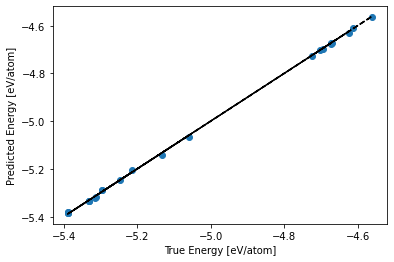

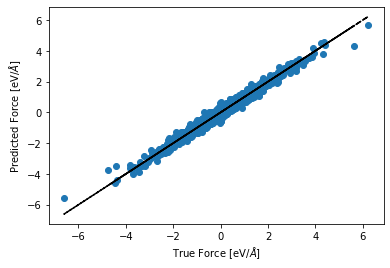

In [91]:
model_lin = LinearPotential(representation)
model_lin.fit_from_features(tr_features, e_t, f_t, e_noise, f_noise, noise_optimization=True)

# evaluate its performances
%time predictions = model_lin.predict_from_features(val_features, forces=True)
ep = predictions['energy']
fp = predictions['forces']
print_score(ep/nat_val, e_val/nat_val)
print_score(fp.flatten(), f_val.flatten())

plt.scatter(e_val/nat_val, ep/nat_val)
plt.plot(e_val/nat_val, e_val/nat_val, 'k--')
plt.xlabel("True Energy [eV/atom]")
plt.ylabel("Predicted Energy [eV/atom]")
plt.show()

plt.scatter(f_val, fp)
plt.plot(f_val, f_val, 'k--')
plt.xlabel("True Force [eV/$\AA$]")
plt.ylabel("Predicted Force [eV/$\AA$]")
plt.show()

### Ensemble Model

Noise Optimization
[############################################################] 5/5
Energy noise: 6.042963902381324e-10, Force noise: 0.0010746078283213173
Noise Optimization
[############################################################] 5/5
Energy noise: 1.2409377607517149e-09, Force noise: 1.2409377607517149e-09
CPU times: user 47.5 ms, sys: 185 ms, total: 232 ms
Wall time: 40.1 ms
MAE=0.005 RMSE=0.007 SUP=0.024 R2=1.000
MAE=0.073 RMSE=0.114 SUP=0.761 R2=0.983


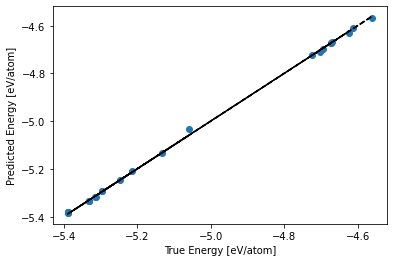

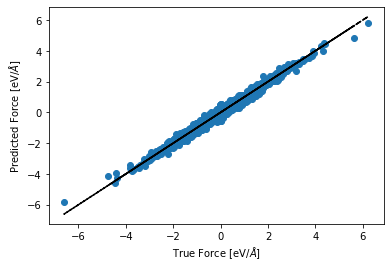

In [108]:
n_clusters = 2
# train the model
model_ens =  LPEnsamble(representation, n_clusters=n_clusters, clustering_type='kmeans', baseline_percentile=0)
model_ens.fit_from_features(tr_features, e_t, f_t, e_noise, f_noise, noise_optimization=True)
# evaluate its performances
%time predictions = model_ens.predict_from_features(val_features, forces=True)
ep = predictions['energy']
fp = predictions['forces']
print_score(ep/nat_val, e_val/nat_val)
print_score(fp.flatten(), f_val.flatten())

plt.scatter(e_val/nat_val, ep/nat_val)
plt.plot(e_val/nat_val, e_val/nat_val, 'k--')
plt.xlabel("True Energy [eV/atom]")
plt.ylabel("Predicted Energy [eV/atom]")
plt.show()

plt.scatter(f_val, fp)
plt.plot(f_val, f_val, 'k--')
plt.xlabel("True Force [eV/$\AA$]")
plt.ylabel("Predicted Force [eV/$\AA$]")
plt.show()

### Ensemble Model with Baseline Model (LJ)

MAE=0.065 RMSE=0.176 SUP=0.028 R2=0.627
MAE=0.333 RMSE=1.098 SUP=22.533 R2=0.568


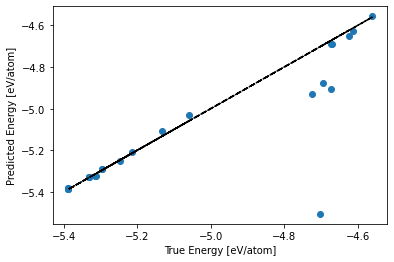

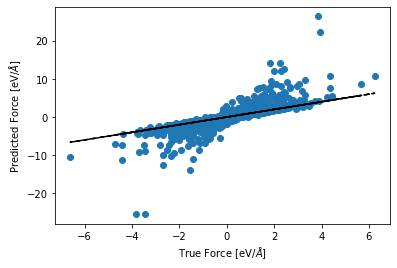

In [16]:
representation = AceGlobalRepresentation(5, 8, rcut, [14], energy_name=energy_name, force_name=force_name)
baseline = LennardJones(epsilon=1.82, sigma=2.2, rc=7, smooth=False)
model_ens_wb =  LPEnsamble(representation, baseline_calculator=baseline, n_clusters=1,
                        clustering_type='kmeans', baseline_percentile=0.001)
model_ens_wb.fit(tr_traj, features=tr_features, e_noise=e_noise, f_noise=f_noise)

ep, fp = [], []
for i in val_traj:
    predictions = model_ens_wb.predict(i, forces=True)
    ep.extend(predictions['energy'])
    fp.extend(predictions['forces'])
ep = np.array(ep)
fp = np.array(fp)

print_score(ep/nat_val, e_val/nat_val)
print_score(fp.flatten(), f_val.flatten())

plt.scatter(e_val/nat_val, ep/nat_val)
plt.plot(e_val/nat_val, e_val/nat_val, 'k--')
plt.xlabel("True Energy [eV/atom]")
plt.ylabel("Predicted Energy [eV/atom]")
plt.show()

plt.scatter(f_val, fp)
plt.plot(f_val, f_val, 'k--')
plt.xlabel("True Force [eV/$\AA$]")
plt.ylabel("Predicted Force [eV/$\AA$]")
plt.show()

# EV Curves

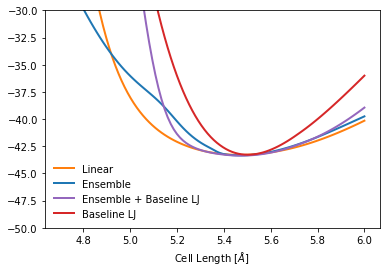

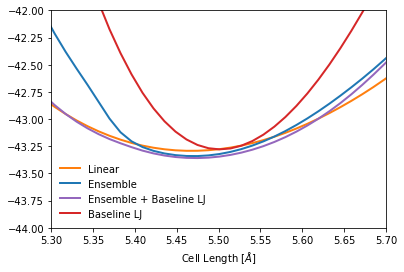

In [17]:
calc_lin = ASEMLCalculator(model_lin)
calc_ens = ASEMLCalculator(model_ens)
calc_ens_wb = ASEMLCalculator(model_ens_wb)
num = 100
en_lin = np.zeros(num)
en_ens = np.zeros(num)
en_ens_wb = np.zeros(num)
en_baseline = np.zeros(num)

distances = np.linspace(4.7, 6, num)
for i in range(num):
    atoms = bulk('Si', 'diamond', a=distances[i], cubic=True)
    atoms.set_calculator(calc_lin)
    en_lin[i] = atoms.get_potential_energy()
    
    atoms.set_calculator(calc_ens)
    en_ens[i] = atoms.get_potential_energy()

    atoms.set_calculator(calc_ens_wb)
    en_ens_wb[i] = atoms.get_potential_energy()
    
    atoms.set_calculator(baseline)
    en_baseline[i] = atoms.get_potential_energy()
    
plt.plot(distances, en_lin, label = 'Linear', lw=2, color = 'tab:orange')
plt.plot(distances, en_ens, label = 'Ensemble', lw=2,  color= 'tab:blue')
plt.plot(distances, en_ens_wb, label = 'Ensemble + Baseline LJ', lw=2, color = 'tab:purple')
plt.plot(distances, en_baseline, label = 'Baseline LJ', lw=2, color = 'tab:red')
plt.legend(frameon=False)
plt.xlabel('Cell Length [$\AA$]')
plt.ylim(-50, -30)
plt.show()

plt.plot(distances, en_lin, label = 'Linear', lw=2, color = 'tab:orange')
plt.plot(distances, en_ens, label = 'Ensemble', lw=2,  color= 'tab:blue')
plt.plot(distances, en_ens_wb, label = 'Ensemble + Baseline LJ', lw=2, color = 'tab:purple')
plt.plot(distances, en_baseline, label = 'Baseline LJ', lw=2, color = 'tab:red')
plt.legend(frameon=False)
plt.xlabel('Cell Length [$\AA$]')
plt.ylim(-44, -42)
plt.xlim(5.3, 5.7)
plt.show()

# MD Runs

In [24]:
atoms = bulk('Si', 'diamond', a=5.5, cubic=True)
atoms.set_calculator(calc_ens)

# Set the momenta corresponding to T=300K
MaxwellBoltzmannDistribution(atoms, temp=5000*units.kB)

# We want to run MD with constant energy using the VelocityVerlet algorithm.
dyn = VelocityVerlet(atoms, 2 * units.fs)  # 5 fs time step.

def printenergy(a):
    """Function to print the potential, kinetic and total energy"""
    epot = a.get_potential_energy() / len(a)
    ekin = a.get_kinetic_energy() / len(a)
    print('Energy per atom: Epot = %.3feV  Ekin = %.3feV (T=%3.0fK)  '
          'Etot = %.3feV' % (epot, ekin, ekin / (1.5 * units.kB), epot + ekin))

# Now run the dynamics
printenergy(atoms)
for i in range(10):
    dyn.run(100)
    printenergy(atoms)

Energy per atom: Epot = -5.415eV  Ekin = 0.672eV (T=5199K)  Etot = -4.743eV
Energy per atom: Epot = -5.050eV  Ekin = 0.309eV (T=2391K)  Etot = -4.741eV
Energy per atom: Epot = -5.086eV  Ekin = 0.344eV (T=2661K)  Etot = -4.742eV
Energy per atom: Epot = -5.109eV  Ekin = 0.367eV (T=2841K)  Etot = -4.742eV
Energy per atom: Epot = -4.891eV  Ekin = 0.151eV (T=1164K)  Etot = -4.740eV
Energy per atom: Epot = -5.016eV  Ekin = 0.275eV (T=2130K)  Etot = -4.741eV
Energy per atom: Epot = -5.130eV  Ekin = 0.389eV (T=3007K)  Etot = -4.742eV
Energy per atom: Epot = -4.967eV  Ekin = 0.226eV (T=1751K)  Etot = -4.741eV
Energy per atom: Epot = -5.014eV  Ekin = 0.272eV (T=2108K)  Etot = -4.741eV
Energy per atom: Epot = -5.028eV  Ekin = 0.287eV (T=2219K)  Etot = -4.741eV
Energy per atom: Epot = -5.159eV  Ekin = 0.417eV (T=3226K)  Etot = -4.742eV


In [25]:
atoms = bulk('Si', 'diamond', a=5.5, cubic=True)
atoms.set_calculator(calc_lin)
dyn = VelocityVerlet(atoms, 3 * units.fs)  # 5 fs time step.

%time dyn.run(100)

CPU times: user 16.3 s, sys: 37.2 s, total: 53.4 s
Wall time: 7.01 s


True

In [26]:
atoms = bulk('Si', 'diamond', a=5.5, cubic=True)
atoms.set_calculator(calc_ens)
dyn = VelocityVerlet(atoms, 3 * units.fs)  # 5 fs time step.

%time dyn.run(100)

CPU times: user 16.2 s, sys: 36.6 s, total: 52.8 s
Wall time: 6.92 s


True

In [8]:
bounds = [1e-10, 1e-2]
noises = np.array([bounds, bounds])
loss = np.inf*np.ones((2, 2))

In [34]:
np.argmin(np.array([[2, 2], [1, 2]]))

2

In [10]:
tr_features.strides.shape

(215,)

In [11]:
tr_features.X.shape

(214, 78)

In [20]:
def kfold(n, k):
    ind = np.arange(n)
    np.random.shuffle(ind)
    fold_ind = [ind[int(k_*n/k):int((k_+1)*n/k)] for k_ in np.arange(k)]
    fold_ind[-1] = ind[int(n*(k-1)/k):]
    return fold_ind

inds = kfold(len(tr_features.X), 5)

In [21]:
trset = np.arange(5)
trset = np.delete(trset, 2)
tr_inds = np.concatenate([inds[i] for i in trset])

In [22]:
np.array([tr_features.strides[i+1] - tr_features.strides[i]  for i in tr_inds])

array([64, 64, 63, 63, 63, 63, 64, 63, 63, 64, 64, 64, 63, 64, 63, 63, 64,
       63, 64, 64, 64, 64, 64, 64, 63, 64, 64, 12, 64, 64, 18, 63, 64, 63,
       63, 64, 64, 63, 64, 64, 63, 63, 64, 64, 64, 64, 64, 63, 64, 63, 63,
       64, 64, 63, 24, 64, 64, 64, 64, 64, 64, 64, 63, 64, 63, 64, 64, 63,
       64, 63, 64, 63, 64, 64, 63, 64, 64, 64, 64, 63, 64, 64, 96, 64, 64,
       64, 24, 64, 64, 40, 63, 64, 64, 63, 63, 64, 64, 64, 64, 64, 64, 64,
       63, 63, 64, 16, 64, 64, 64, 64, 64, 64, 64, 64, 64, 63, 64, 63, 64,
       64, 64, 64, 64, 64, 64, 63, 63, 63, 63, 63, 64, 63, 64, 64, 64, 64,
       64, 64, 64, 64, 64, 64, 63, 64, 64, 63, 64, 36, 64, 63, 64, 63, 64,
       64, 64, 64, 24, 64, 64, 63, 64, 16, 64, 64, 36, 64, 63, 64, 64, 20,
       64])

In [23]:
tr_features.strides

array([    0,    63,   126,   189,   252,   315,   378,   441,   504,
         567,   630,   693,   756,   819,   882,   945,  1008,  1071,
        1134,  1197,  1260,  1323,  1386,  1449,  1512,  1575,  1638,
        1701,  1764,  1827,  1890,  1953,  2016,  2079,  2142,  2205,
        2268,  2331,  2394,  2457,  2520,  2583,  2646,  2709,  2772,
        2835,  2898,  2961,  3024,  3087,  3150,  3213,  3276,  3339,
        3402,  3465,  3528,  3591,  3615,  3651,  3675,  3715,  3811,
        3847,  3863,  3879,  3891,  3915,  3933,  3953,  4017,  4081,
        4145,  4209,  4273,  4337,  4401,  4465,  4529,  4593,  4657,
        4721,  4785,  4849,  4913,  4977,  5041,  5105,  5169,  5233,
        5297,  5361,  5425,  5489,  5553,  5617,  5681,  5745,  5809,
        5873,  5937,  6001,  6065,  6129,  6193,  6257,  6321,  6385,
        6449,  6513,  6577,  6641,  6705,  6769,  6833,  6897,  6961,
        7025,  7089,  7153,  7217,  7281,  7345,  7409,  7473,  7537,
        7601,  7665,

In [28]:
bounds = [1e-10, 1e-2]
maxiter=10
kfold=5
noises = np.array([bounds, bounds])
loss = np.zeros((2, 2))
for i in np.arange(maxiter):
    for j in np.arange(4):
        en = noises[0, j%2]
        fn = noises[1, j//2]

In [32]:
2//2

1